In [1]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import random
import math
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from dataset import get_dataset
from utils import alphabar_t
from model import Model
from generate import train_sample
import os

torch.backends.cudnn.benchmark = True


/home/bigbrainman/deepvenv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
T = 35
S = 0.0008
BATCH_SIZE = 128

In [3]:
train_set = get_dataset(T)

Files already downloaded and verified


In [4]:
g = make_grid([train_set[random.randint(0, len(train_set) -1)][1] for _ in range(25)], 5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 32, 32])


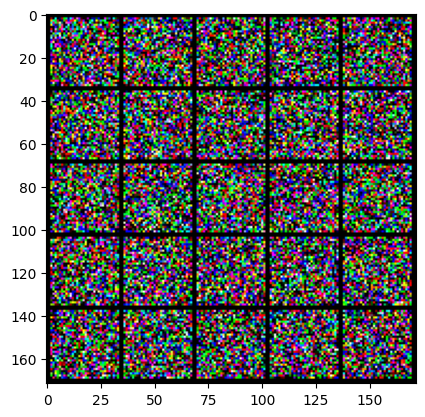

In [5]:
plt.imshow(g.permute(1, 2, 0))
print(train_set[0][0].shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


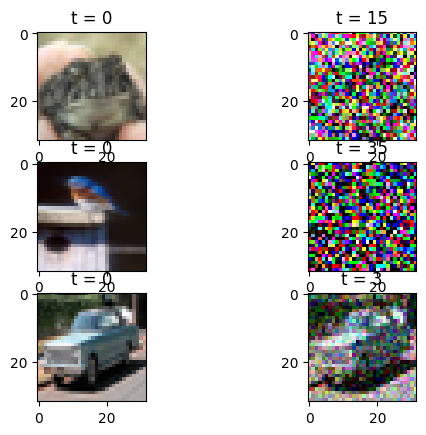

In [6]:
fig, axes = plt.subplots(3, 2)

for i in range(3):
    idx = random.randint(1, T - 1)
    axrow = axes[i]

    noise_img, eps, img, t = train_set[idx]

    axrow[0].imshow(img.permute(1, 2, 0), cmap='gray')
    axrow[0].set_title('t = 0')

    axrow[1].imshow(noise_img.permute(1, 2, 0), cmap='gray')
    axrow[1].set_title(f"t = {t}")

In [7]:
net = Model(u_depth = 5, block_size=3, h_channels = 10).to(device)

iters = 0

if os.path.exists('./models') and len(list(os.walk('./models'))[0][2]) >= 2:

    highest = 0
    for p in list(os.walk('./models'))[0][2]:
        
        highest = max(highest, int(os.path.splitext(p)[0]))

    print(f"loading {highest}")
    path = f'./models/{highest}.pth'
    print(path)
    net.load_state_dict(torch.load(path))
    iters = highest

summary(net, (3, 32, 32), device=device)

loading 9000
./models/9000.pth
no t
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
SinusoidalPositionEmbeddings-1                    [-1, 6]               0
SinusoidalPositionEmbeddings-2                    [-1, 6]               0
            Conv2d-3           [-1, 10, 32, 32]             280
            Linear-4                   [-1, 10]              70
            Conv2d-5           [-1, 10, 32, 32]             910
       BatchNorm2d-6           [-1, 10, 32, 32]              20
              ReLU-7           [-1, 10, 32, 32]               0
           Dropout-8           [-1, 10, 32, 32]               0
            Conv2d-9           [-1, 10, 32, 32]             910
      BatchNorm2d-10           [-1, 10, 32, 32]              20
             ReLU-11           [-1, 10, 32, 32]               0
          Dropout-12           [-1, 10, 32, 32]               0
           Conv2d-13           [-1, 10, 32, 32]

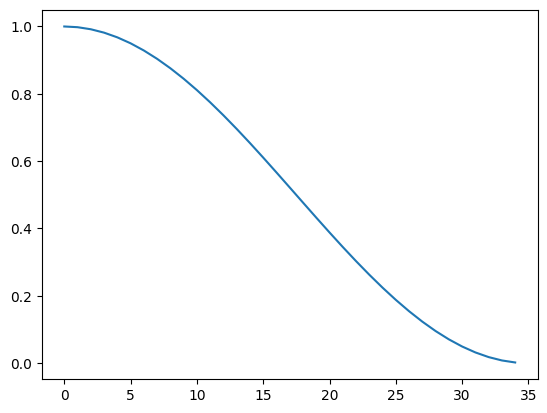

In [8]:
# precache the alpha_bars
a_bar = alphabar_t(torch.arange(0, T), T, S)

plt.plot(a_bar)


In [9]:
train_dl = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

In [10]:
loss_fn = torch.nn.MSELoss()
optim = torch.optim.Adam(net.parameters(), lr=0.00001, amsgrad=True)

In [11]:
iters_print = 20

iters_generate = 200


for i in range(100):
    print_loss = 0

    for noise_img, eps, img, t in train_dl:


        noise_img = noise_img.to(device)
        eps = eps.to(device)
        t = t.to(device)

        net.train()
        out = net(noise_img, t)

        loss = loss_fn(out, eps)

        optim.zero_grad()

        loss.backward()

        optim.step()

        print_loss += loss.item()


        iters += 1

        if iters % iters_print == 0:
            l = print_loss / iters_print
            print_loss = 0
            print(f"[iter {iters}] loss: {l}")


        if iters % iters_generate == 0:
            torch.save(net.state_dict(), f'./models/{iters}.pth')
            net.eval()
            with torch.no_grad():
                train_sample(20, T, net, iters, shape=(3, 32, 32))


[iter 9020] loss: 0.12374823838472367
[iter 9040] loss: 0.12326056510210037
[iter 9060] loss: 0.1202995777130127
[iter 9080] loss: 0.11952375061810017
[iter 9100] loss: 0.11434725821018218
[iter 9120] loss: 0.11621371433138847
[iter 9140] loss: 0.11300698444247245
[iter 9160] loss: 0.11130035556852817
[iter 9180] loss: 0.11256681457161903
[iter 9200] loss: 0.10937209241092205


100%|██████████| 34/34 [00:00<00:00, 38.26it/s]


[iter 9220] loss: 0.1095675729215145
[iter 9240] loss: 0.10810647010803223
[iter 9260] loss: 0.11267653964459896
[iter 9280] loss: 0.10959434881806374
[iter 9300] loss: 0.10697648636996746
[iter 9320] loss: 0.10801197700202465
[iter 9340] loss: 0.10940593555569648
[iter 9360] loss: 0.10427954532206059
[iter 9380] loss: 0.10435873717069626
[iter 9400] loss: 0.046824827790260315


100%|██████████| 34/34 [00:00<00:00, 60.52it/s]


[iter 9420] loss: 0.10280201658606529
[iter 9440] loss: 0.10035127848386764
[iter 9460] loss: 0.10024593658745289
[iter 9480] loss: 0.10190678350627422
[iter 9500] loss: 0.0986470092087984
[iter 9520] loss: 0.10121843926608562
[iter 9540] loss: 0.09743639715015888
[iter 9560] loss: 0.10072507560253144
[iter 9580] loss: 0.0965098723769188
[iter 9600] loss: 0.09800855666399003


100%|██████████| 34/34 [00:00<00:00, 60.02it/s]


[iter 9620] loss: 0.09728793762624263
[iter 9640] loss: 0.09624913670122623
[iter 9660] loss: 0.09541361480951309
[iter 9680] loss: 0.09461117759346963
[iter 9700] loss: 0.09414176009595394
[iter 9720] loss: 0.09274261519312858
[iter 9740] loss: 0.09784629084169864
[iter 9760] loss: 0.09187516085803508
[iter 9780] loss: 0.09302533976733685
[iter 9800] loss: 0.08123313598334789


100%|██████████| 34/34 [00:00<00:00, 60.68it/s]


[iter 9820] loss: 0.09059237875044346
[iter 9840] loss: 0.08911415562033653
[iter 9860] loss: 0.09136585108935832
[iter 9880] loss: 0.09158351942896843
[iter 9900] loss: 0.09010884389281273
[iter 9920] loss: 0.09071034267544746
[iter 9940] loss: 0.0872934713959694
[iter 9960] loss: 0.09002485312521458
[iter 9980] loss: 0.0897315874695778
[iter 10000] loss: 0.09105880111455918


100%|██████████| 34/34 [00:00<00:00, 60.59it/s]


[iter 10020] loss: 0.08914670646190644
[iter 10040] loss: 0.0892724920064211
[iter 10060] loss: 0.08589626587927342
[iter 10080] loss: 0.0886308316141367
[iter 10100] loss: 0.08713459186255931
[iter 10120] loss: 0.08815159648656845
[iter 10140] loss: 0.0866093397140503
[iter 10160] loss: 0.08987413719296455
[iter 10180] loss: 0.028370636329054833
[iter 10200] loss: 0.0857336599379778


100%|██████████| 34/34 [00:00<00:00, 60.42it/s]


[iter 10220] loss: 0.08516091704368592
[iter 10240] loss: 0.08427527509629726
[iter 10260] loss: 0.08470717892050743
[iter 10280] loss: 0.08850310891866683
[iter 10300] loss: 0.08524344488978386
[iter 10320] loss: 0.08643733821809292
[iter 10340] loss: 0.08314607739448547
[iter 10360] loss: 0.08558377251029015
[iter 10380] loss: 0.08297951892018318
[iter 10400] loss: 0.08444631062448024


100%|██████████| 34/34 [00:00<00:00, 61.07it/s]


[iter 10420] loss: 0.08290396071970463
[iter 10440] loss: 0.08470733687281609
[iter 10460] loss: 0.08252487368881703
[iter 10480] loss: 0.08408844880759717
[iter 10500] loss: 0.0822772216051817
[iter 10520] loss: 0.08301793113350868
[iter 10540] loss: 0.0800071343779564
[iter 10560] loss: 0.07993548810482025
[iter 10580] loss: 0.06395154818892479
[iter 10600] loss: 0.08249581195414066


100%|██████████| 34/34 [00:00<00:00, 61.16it/s]


[iter 10620] loss: 0.07882270514965058
[iter 10640] loss: 0.08105222061276436
[iter 10660] loss: 0.07761602737009525
[iter 10680] loss: 0.0800438780337572
[iter 10700] loss: 0.0806935641914606
[iter 10720] loss: 0.08205755949020385
[iter 10740] loss: 0.07912391610443592
[iter 10760] loss: 0.07940285131335259
[iter 10780] loss: 0.07949980683624744
[iter 10800] loss: 0.07885435111820698


100%|██████████| 34/34 [00:00<00:00, 60.35it/s]


[iter 10820] loss: 0.07989483289420604
[iter 10840] loss: 0.07977067418396473
[iter 10860] loss: 0.07963375039398671
[iter 10880] loss: 0.07722767181694508
[iter 10900] loss: 0.07837652936577796
[iter 10920] loss: 0.07997904866933822
[iter 10940] loss: 0.08055771104991435
[iter 10960] loss: 0.02030787616968155
[iter 10980] loss: 0.08018581718206405
[iter 11000] loss: 0.07975674495100975


100%|██████████| 34/34 [00:00<00:00, 60.72it/s]


[iter 11020] loss: 0.07938538193702697
[iter 11040] loss: 0.07785897254943848
[iter 11060] loss: 0.07580968141555786
[iter 11080] loss: 0.0779389027506113
[iter 11100] loss: 0.0790923323482275
[iter 11120] loss: 0.07529774978756905
[iter 11140] loss: 0.07881942801177502
[iter 11160] loss: 0.07878445573151112
[iter 11180] loss: 0.07980738766491413
[iter 11200] loss: 0.07468769140541553


100%|██████████| 34/34 [00:00<00:00, 59.77it/s]


[iter 11220] loss: 0.07612105868756772
[iter 11240] loss: 0.0779705174267292
[iter 11260] loss: 0.07702930606901645
[iter 11280] loss: 0.07663941606879235
[iter 11300] loss: 0.07727516479790211
[iter 11320] loss: 0.08235294930636883
[iter 11340] loss: 0.0769264254719019
[iter 11360] loss: 0.056258748099207875
[iter 11380] loss: 0.08062498159706592
[iter 11400] loss: 0.07674155384302139


100%|██████████| 34/34 [00:00<00:00, 61.09it/s]


[iter 11420] loss: 0.07605162523686886
[iter 11440] loss: 0.07744568213820457
[iter 11460] loss: 0.0762370377779007
[iter 11480] loss: 0.07829568646848202
[iter 11500] loss: 0.07440712936222553
[iter 11520] loss: 0.07658663503825665
[iter 11540] loss: 0.07773083299398423
[iter 11560] loss: 0.07641586661338806
[iter 11580] loss: 0.07605778202414512
[iter 11600] loss: 0.0764131300151348


100%|██████████| 34/34 [00:00<00:00, 61.05it/s]


[iter 11620] loss: 0.07655503191053867
[iter 11640] loss: 0.07552170753479004
[iter 11660] loss: 0.07475206516683101
[iter 11680] loss: 0.07509512417018413
[iter 11700] loss: 0.07683481089770794
[iter 11720] loss: 0.07457309737801551
[iter 11740] loss: 0.011534600332379342
[iter 11760] loss: 0.07387366332113743
[iter 11780] loss: 0.0762811565771699
[iter 11800] loss: 0.07538236230611801


100%|██████████| 34/34 [00:00<00:00, 60.97it/s]


[iter 11820] loss: 0.0773068718612194
[iter 11840] loss: 0.07576063349843025
[iter 11860] loss: 0.07667589783668519
[iter 11880] loss: 0.07388017922639847
[iter 11900] loss: 0.07371180579066276
[iter 11920] loss: 0.07473480477929115
[iter 11940] loss: 0.07354574054479598
[iter 11960] loss: 0.07489346303045749
[iter 11980] loss: 0.07446919865906239
[iter 12000] loss: 0.07757824026048184


100%|██████████| 34/34 [00:00<00:00, 60.19it/s]


[iter 12020] loss: 0.07388754449784755
[iter 12040] loss: 0.07824881374835968
[iter 12060] loss: 0.0737167876213789
[iter 12080] loss: 0.0712055554613471
[iter 12100] loss: 0.07431336864829063
[iter 12120] loss: 0.07477723844349385
[iter 12140] loss: 0.0433546531945467
[iter 12160] loss: 0.07345686256885528
[iter 12180] loss: 0.07427444867789745
[iter 12200] loss: 0.07239462956786155


100%|██████████| 34/34 [00:00<00:00, 61.31it/s]


[iter 12220] loss: 0.07480690591037273
[iter 12240] loss: 0.07458400130271911
[iter 12260] loss: 0.07202067635953427
[iter 12280] loss: 0.0744273118674755
[iter 12300] loss: 0.07672105506062507
[iter 12320] loss: 0.07625367306172848
[iter 12340] loss: 0.0713081955909729
[iter 12360] loss: 0.07306566499173642
[iter 12380] loss: 0.07288733199238777
[iter 12400] loss: 0.0700045021250844


100%|██████████| 34/34 [00:00<00:00, 60.48it/s]


[iter 12420] loss: 0.07332386523485183
[iter 12440] loss: 0.07202444411814213
[iter 12460] loss: 0.07276327162981033
[iter 12480] loss: 0.07459239326417447
[iter 12500] loss: 0.07215358838438987
[iter 12520] loss: 0.003712129220366478
[iter 12540] loss: 0.07210994567722082
[iter 12560] loss: 0.06965355481952429
[iter 12580] loss: 0.07052635811269284
[iter 12600] loss: 0.07293130233883857


100%|██████████| 34/34 [00:00<00:00, 58.92it/s]


[iter 12620] loss: 0.07477024421095849
[iter 12640] loss: 0.07295962758362293
[iter 12660] loss: 0.07202162351459265
[iter 12680] loss: 0.07308914195746183
[iter 12700] loss: 0.07460375856608152
[iter 12720] loss: 0.07232853062450886
[iter 12740] loss: 0.07341929152607918
[iter 12760] loss: 0.07294289227575064
[iter 12780] loss: 0.07333073057234288
[iter 12800] loss: 0.07479216009378434


100%|██████████| 34/34 [00:00<00:00, 61.35it/s]


[iter 12820] loss: 0.07344295047223567
[iter 12840] loss: 0.07577120140194893
[iter 12860] loss: 0.07404746282845735
[iter 12880] loss: 0.07641845010221004
[iter 12900] loss: 0.07499255277216435
[iter 12920] loss: 0.03666308969259262
[iter 12940] loss: 0.07190675511956215
[iter 12960] loss: 0.07081576772034168
[iter 12980] loss: 0.06985666900873184
[iter 13000] loss: 0.07293341998010874


100%|██████████| 34/34 [00:00<00:00, 61.29it/s]


[iter 13020] loss: 0.07044590525329113
[iter 13040] loss: 0.07139659691601992
[iter 13060] loss: 0.07021729070693254
[iter 13080] loss: 0.07020017951726913
[iter 13100] loss: 0.06977759879082442
[iter 13120] loss: 0.07159300222992897
[iter 13140] loss: 0.07191891595721245
[iter 13160] loss: 0.06988215930759907
[iter 13180] loss: 0.07123691216111183
[iter 13200] loss: 0.07172080297023058


100%|██████████| 34/34 [00:00<00:00, 60.83it/s]


[iter 13220] loss: 0.07035940587520599
[iter 13240] loss: 0.06959388237446547
[iter 13260] loss: 0.06881452407687902
[iter 13280] loss: 0.07055027391761541
[iter 13300] loss: 0.06957070250064135
[iter 13320] loss: 0.0686169920489192
[iter 13340] loss: 0.07002456113696098
[iter 13360] loss: 0.07217683233320712
[iter 13380] loss: 0.06785893067717552
[iter 13400] loss: 0.06935268249362707


100%|██████████| 34/34 [00:00<00:00, 60.45it/s]


[iter 13420] loss: 0.07159542702138424
[iter 13440] loss: 0.06817501913756133
[iter 13460] loss: 0.0682737223803997
[iter 13480] loss: 0.07132981307804584
[iter 13500] loss: 0.06916983984410763
[iter 13520] loss: 0.06877263300120831
[iter 13540] loss: 0.06856435220688581
[iter 13560] loss: 0.06645547728985549
[iter 13580] loss: 0.07164777629077435
[iter 13600] loss: 0.07123352400958538


100%|██████████| 34/34 [00:00<00:00, 60.07it/s]


[iter 13620] loss: 0.07180298753082752
[iter 13640] loss: 0.06966566406190396
[iter 13660] loss: 0.07113248500972986
[iter 13680] loss: 0.06876824796199799
[iter 13700] loss: 0.030285578593611716
[iter 13720] loss: 0.06850858554244041
[iter 13740] loss: 0.07039752714335919
[iter 13760] loss: 0.07162536196410656
[iter 13780] loss: 0.07184852324426175
[iter 13800] loss: 0.0704274520277977


100%|██████████| 34/34 [00:00<00:00, 60.40it/s]


[iter 13820] loss: 0.06860201265662909
[iter 13840] loss: 0.07215388771146536
[iter 13860] loss: 0.06989965494722128
